# Imports and environment


In [2]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_004
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset


In [ ]:
dataset = BNCI2014_004()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["4test"]["0"]

<RawArray | 7 x 474363 (1897.5 s), ~25.3 MiB, data loaded>

# Prepare train and test data


In [34]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": -1, "right_hand": 1}

for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1train")
    sess_3_mask = (metadata["subject"] == subject) & (metadata["session"] == "2train")
    sess_4_mask = (metadata["subject"] == subject) & (metadata["session"] == "3test")
    sess_5_mask = (metadata["subject"] == subject) & (metadata["session"] == "4test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]
    X_sess_3 = X_all[sess_3_mask]
    y_sess_3 = y_all[sess_3_mask]
    X_sess_4 = X_all[sess_4_mask]
    y_sess_4 = y_all[sess_4_mask]
    X_sess_5 = X_all[sess_5_mask]
    y_sess_5 = y_all[sess_5_mask]

    X_sess_1_feat = extract_welch_features(X_sess_1)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = extract_welch_features(X_sess_2)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])
    X_sess_3_feat = extract_welch_features(X_sess_3)
    y_sess_3 = np.array([label_map[label] for label in y_sess_3])
    X_sess_4_feat = extract_welch_features(X_sess_4)
    y_sess_4 = np.array([label_map[label] for label in y_sess_4])
    X_sess_5_feat = extract_welch_features(X_sess_5)
    y_sess_5 = np.array([label_map[label] for label in y_sess_5])

    X_subject_train = np.empty(4, dtype=object)
    X_subject_train[0] = X_sess_1_feat.T
    X_subject_train[1] = X_sess_2_feat.T
    X_subject_train[2] = X_sess_3_feat.T
    X_subject_train[3] = X_sess_4_feat.T
    y_subject_train = np.empty(4, dtype=object)
    y_subject_train[0] = y_sess_1.reshape(-1, 1)
    y_subject_train[1] = y_sess_2.reshape(-1, 1)
    y_subject_train[2] = y_sess_3.reshape(-1, 1)
    y_subject_train[3] = y_sess_4.reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_5_feat.T
    y_test[idx] = y_sess_5.reshape(-1, 1)

2025-07-10 12:24:27,662 - INFO - Data shape: (120, 3, 1126)
2025-07-10 12:24:27,830 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-10 12:24:27,831 - INFO - Data shape: (120, 3, 1126)
2025-07-10 12:24:27,999 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-10 12:24:27,999 - INFO - Data shape: (160, 3, 1126)
2025-07-10 12:24:28,221 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-10 12:24:28,221 - INFO - Data shape: (160, 3, 1126)
2025-07-10 12:24:28,439 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-10 12:24:28,440 - INFO - Data shape: (160, 3, 1126)
2025-07-10 12:24:28,662 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-10 12:24:28,669 - INFO - Data shape: (120, 3, 1126)
2025-07-10 12:24:28,835 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-10 12:24:28,836 - INFO - Data shape: (120, 3, 1126)
2025-07-10 12:24:29,005 - INFO - Welch features extracted, vector's sh

# Testing linear multi-task classifier (Algorithm 1)


In [37]:
accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-07-10 12:26:06,182 - INFO - Iteration 1, error = 14.556872163411947
2025-07-10 12:26:06,186 - INFO - Iteration 2, error = 2.57885230295644
2025-07-10 12:26:06,189 - INFO - Iteration 3, error = 0.8249000760271266
2025-07-10 12:26:06,192 - INFO - Iteration 4, error = 0.6372327661737541
2025-07-10 12:26:06,195 - INFO - Iteration 5, error = 0.5814368198556047
2025-07-10 12:26:06,198 - INFO - Iteration 6, error = 0.5848963271067895
2025-07-10 12:26:06,201 - INFO - Iteration 7, error = 0.5786012578002577
2025-07-10 12:26:06,204 - INFO - Iteration 8, error = 0.45405126523375605
2025-07-10 12:26:06,206 - INFO - Iteration 9, error = 0.18961984221819622
2025-07-10 12:26:06,209 - INFO - Iteration 10, error = 0.027275285690717986
2025-07-10 12:26:06,211 - INFO - Iteration 11, error = 0.009638131650134383
2025-07-10 12:26:06,214 - INFO - Iteration 12, error = 0.005643315753375151
2025-07-10 12:26:06,217 - INFO - Iteration 13, error = 0.0034773981805798263
2025-07-10 12:26:06,220 - INFO - Itera

# Plot Algorithm 1 results


Text(0.5, 0, 'Subject')

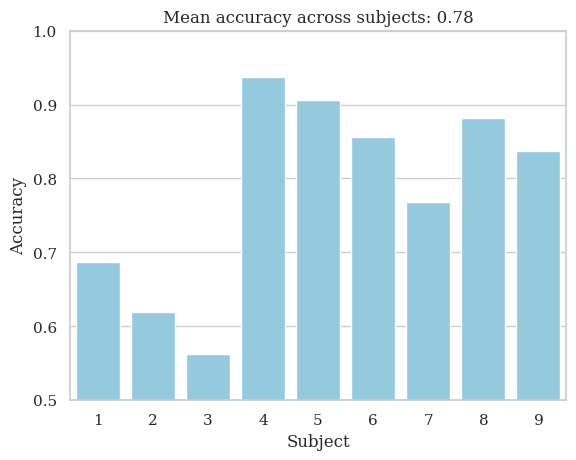

In [26]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_1_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")

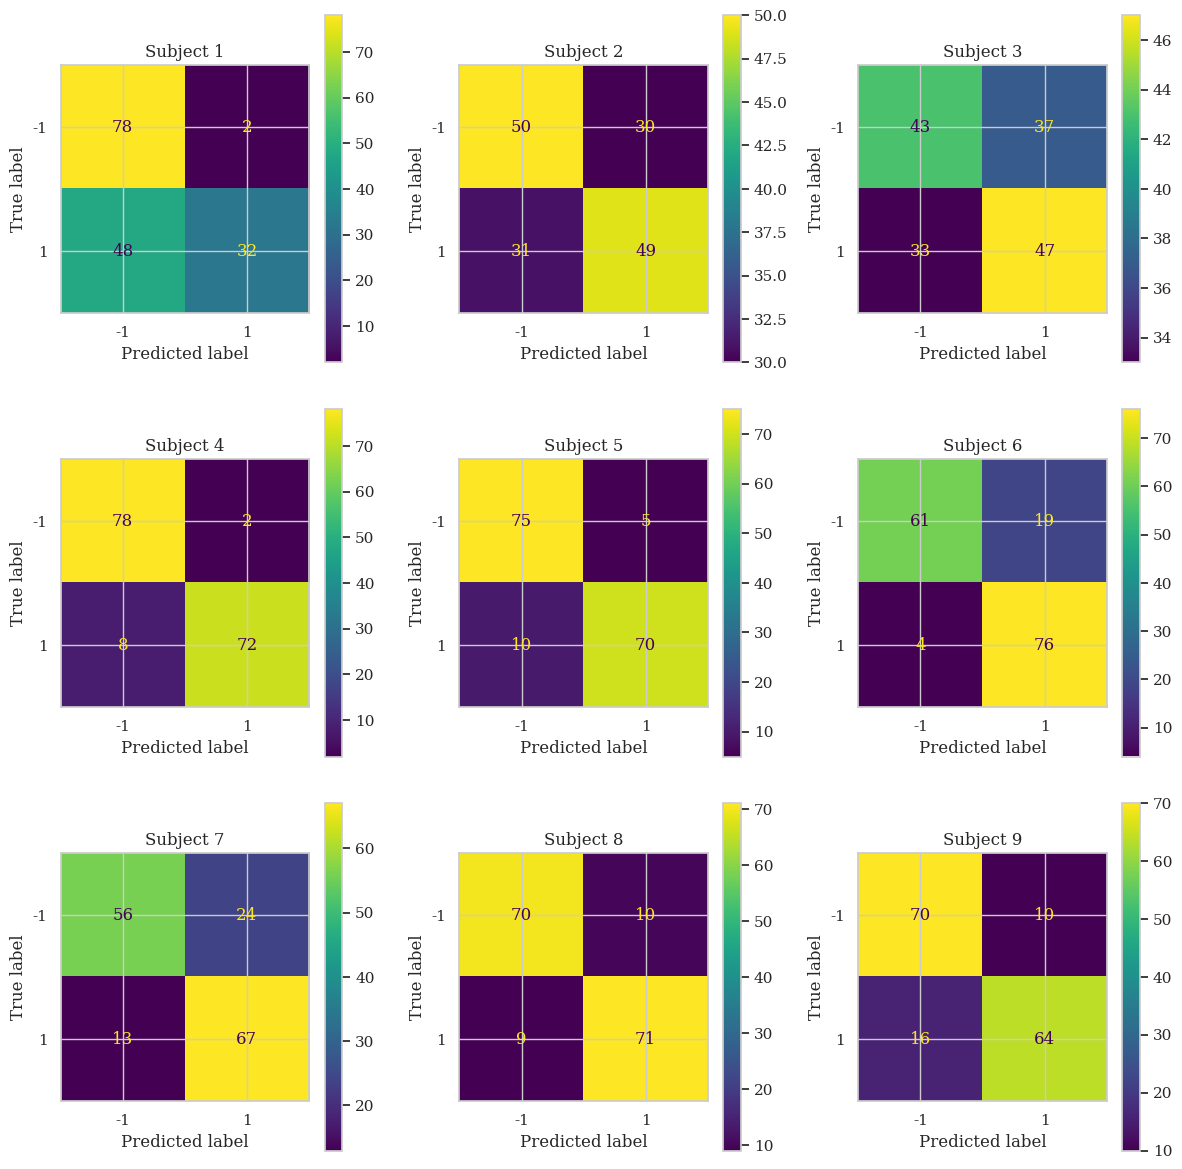

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Subject {subj_idx}")
plt.tight_layout()

# Testing linear multi-task classifier with data selection (Algorithm 2)


In [27]:
accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])
    clf.fit(X_test[idx], y_test[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-07-10 12:18:15,327 - INFO - Iteration 1, error = 14.556872163411947
2025-07-10 12:18:15,330 - INFO - Iteration 2, error = 2.57885230295644
2025-07-10 12:18:15,336 - INFO - Iteration 3, error = 0.8249000760271266
2025-07-10 12:18:15,339 - INFO - Iteration 4, error = 0.6372327661737541
2025-07-10 12:18:15,343 - INFO - Iteration 5, error = 0.5814368198556047
2025-07-10 12:18:15,346 - INFO - Iteration 6, error = 0.5848963271067895
2025-07-10 12:18:15,350 - INFO - Iteration 7, error = 0.5786012578002577
2025-07-10 12:18:15,353 - INFO - Iteration 8, error = 0.45405126523375605
2025-07-10 12:18:15,356 - INFO - Iteration 9, error = 0.18961984221819622
2025-07-10 12:18:15,360 - INFO - Iteration 10, error = 0.027275285690717986
2025-07-10 12:18:15,363 - INFO - Iteration 11, error = 0.009638131650134383
2025-07-10 12:18:15,366 - INFO - Iteration 12, error = 0.005643315753375151
2025-07-10 12:18:15,370 - INFO - Iteration 13, error = 0.0034773981805798263
2025-07-10 12:18:15,374 - INFO - Itera

# Plot algorithm 2 results


Text(0.5, 0, 'Subject')

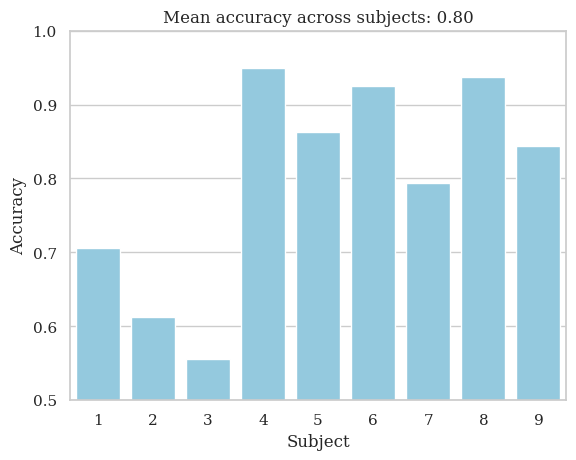

In [29]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_2_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")